Let's train SEAE with Fast.ai

In [9]:
import os
import torch
from torch import nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchaudio import transforms
from torch.utils.data.sampler import SubsetRandomSampler
from data import SpeechDataset
import time
from model import Autoencoder
from transformer import Transformer
import pdb
import matplotlib.pyplot as plt
from pypesq import pesq
import torch.nn.functional as F
import torchaudio
from tqdm.notebook import trange, tqdm
from IPython.display import Audio
from fastai.vision import *
import numpy as np

In [10]:
EXPLORE = True

In [11]:
batch_size = 128

In [12]:
dataset = SpeechDataset('data/clean/360/', 'data/noise/', window_size=16384, overlap=50, snr=10)

dataset_size = len(dataset)
if EXPLORE:
    dataset_size = batch_size * 3
indices = list(range(dataset_size))
validation_split = .2
split = int(np.floor(validation_split * dataset_size))
train_indices, val_indices = indices[split:], indices[:split]

train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)

train_loader = DataLoader(dataset, batch_size=batch_size, sampler=train_sampler)
validation_loader = DataLoader(dataset, batch_size=batch_size, sampler=valid_sampler)

In [13]:
#MODEL_PATH = f'models/after_6_cycles.pth'
model = Autoencoder(bs=batch_size).cuda()
#model.load_state_dict(torch.load(MODEL_PATH))

In [6]:
def myLoss(output, target):
    print(output.shape, target.shape)
    output = output.view(-1, 16384)
    target = target.view(-1, 16384)
    criterion = nn.CrossEntropyLoss()
    pdb.set_trace()
    loss = criterion(output,target)
    
    return loss

In [14]:
data = DataBunch(train_loader, validation_loader)
learner = Learner(data, model, opt_func=torch.optim.RMSprop, loss_func=nn.MSELoss(), callback_fns=ShowGraph)

In [15]:
learner.lr_find()

epoch,train_loss,valid_loss,time
0,0.012078,#na#,00:02
1,0.012034,#na#,00:02
2,0.012076,#na#,00:02
3,0.012011,#na#,00:02
4,0.012028,#na#,00:02
5,0.011973,#na#,00:02
6,0.011935,#na#,00:02
7,0.011819,#na#,00:02
8,0.011656,#na#,00:02
9,0.011404,#na#,00:02


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


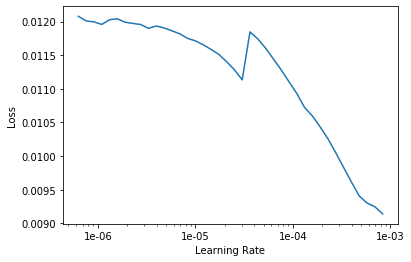

In [16]:
learner.recorder.plot()

epoch,train_loss,valid_loss,time
0,0.000959,0.000768,00:02
1,0.000950,0.000763,00:02
2,0.000934,0.000753,00:02
3,0.000912,0.000741,00:02
4,0.000902,0.000725,00:02
5,0.000897,0.000713,00:02
6,0.000885,0.000707,00:02
7,0.000872,0.000696,00:02
8,0.000859,0.000687,00:02
9,0.000846,0.000677,00:02


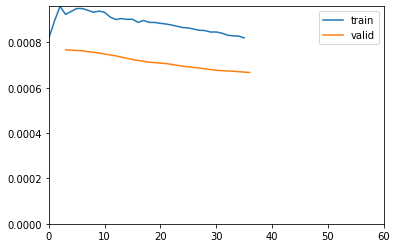

In [ ]:
learner.fit_one_cycle(20, 1e-5)

In [17]:
torch.save(model.state_dict(), f'models/attn_3_cycle.pth')

#### Let's hear how the model denoises

In [11]:
from pypesq import pesq

0.2524


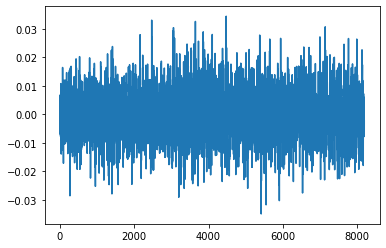

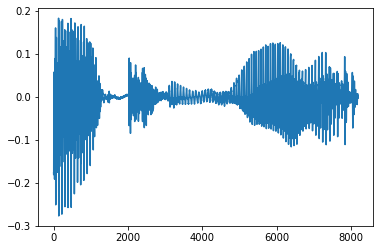

In [13]:
pesqs = []

data = dataset[0]
model.eval()
with torch.no_grad():
    sample = data[0].cuda()
    output = model(data[0].reshape(-1, 1, 16384).cuda())
    ref = output[0, :, :].cpu().detach().numpy().T[:, 0]
    target = data[1][0, :].cpu().detach().numpy().T[:]
    plt.figure()
    plt.plot(ref)
    plt.figure()
    plt.plot(target)

    pesqs.append(pesq(target, ref, 16000))
        
print(round(sum(pesqs) / len(pesqs), 4))
# Change between ref/target to hear model output/original
Audio(ref, rate=16000)

In [24]:
src = dataset[0][0].reshape(1,1, 16384)
encoder_layer = nn.TransformerEncoderLayer(d_model=16384, nhead=4)
#src = torch.rand(10, 32, 512)
out = encoder_layer(src)
print(out.shape)

torch.Size([1, 1, 16384])
torch.Size([1, 1, 16384])
